In [16]:
# 必要なライブラリのインポート
import json
import shap
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

### ファイルパスを指定

In [17]:
with open("combined_feedback_data.json", "r") as f:
    data = json.load(f)

### SAE特徴とsycophancy_flagをセットで取り出す

In [18]:
feedback_results = data["results"]

In [19]:
def extract_activations(feedback_results):
    activations = []
    for result in feedback_results:
        for variation in result["variations"]:
            activations.append(variation["sae_activations"])
    return activations

def extract_sycophancy_flags(feedback_results):
    sycophancy_flags = []
    for result in feedback_results:
        for variation in result["variations"]:
            sycophancy_flags.append(variation["sycophancy_flag"])
    return sycophancy_flags

def extract_shap_data(feedback_results):
    activation_list = extract_activations(feedback_results)
    sycophancy_flag_list = extract_sycophancy_flags(feedback_results)
    return activation_list, sycophancy_flag_list


In [20]:
activation_list, sycophancy_flag_list = extract_shap_data(feedback_results)

### lighgbmに入れられる形に変換

In [ ]:
key_list = []

for activation in activation_list:
    x = activation["prompt_last_token"]
    for key in x.keys():
        if key not in key_list:
            key_list.append(key)

In [22]:
key_list.append("sycophancy_flag")

In [23]:
df = pd.DataFrame(index=range(len(activation_list)), columns=key_list)

In [24]:
for column in list(df.columns):
    for i, activation in enumerate(activation_list):
        if column == "sycophancy_flag":
            df.at[i, column] = sycophancy_flag_list[i]
        elif column in activation["prompt_last_token"]:
            df.at[i, column] = activation["prompt_last_token"][column]
        else:
            df.at[i, column] = 0.0


In [25]:
df

,324,481,578,585,728,781,784,1012,1061,1091,...,4997,7689,8401,11435,10324,2373,4949,6323,9462,sycophancy_flag
0,11.772817,21.623665,14.940629,13.333556,49.495682,10.694131,46.283928,13.346848,30.61269,11.565969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9.992742,18.283695,10.270989,14.570526,48.805237,11.477237,48.533615,10.957276,25.314049,17.395561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,13.122322,20.906551,14.098269,12.269262,47.238991,10.863017,46.925568,14.092957,23.623997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.243311,16.900177,9.520466,14.920532,48.666824,13.825068,48.747017,0.0,17.427433,13.745048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,12.173222,18.740519,14.281058,14.6404,48.286308,11.330106,49.531349,12.639008,29.621445,13.553303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0.0,0.0,0.0,18.728079,40.940186,0.0,33.161186,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5496,0.0,0.0,0.0,15.923285,41.577385,0.0,28.524179,9.581547,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5497,0.0,0.0,0.0,18.348246,45.136726,0.0,31.965483,9.440088,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5498,0.0,0.0,0.0,17.252775,44.368073,0.0,29.856539,10.273693,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### lightgbmを利用してsycophanacy_flagを予測するモデルを構築

In [26]:
# sycophancy_flagの値の分布を確認
print("=== sycophancy_flagの分布 ===")
print(df['sycophancy_flag'].value_counts().sort_index())
print(f"\nユニークな値: {df['sycophancy_flag'].unique()}")
print(f"データ型: {df['sycophancy_flag'].dtype}")
print(f"\n総サンプル数: {len(df)}")

=== sycophancy_flagの分布 ===
sycophancy_flag
-1       3
0     3541
1     1956
Name: count, dtype: int64

ユニークな値: [0 1 -1]
データ型: object

総サンプル数: 5500


In [27]:
# sycophancy_flagが-1の行を削除
df = df[df['sycophancy_flag'] != -1]
print(f"フィルタ後のデータサンプル数: {len(df)}")
print(f"フィルタ後のsycophancy_flagの分布:\n{df['sycophancy_flag'].value_counts().sort_index()}")

フィルタ後のデータサンプル数: 5497
フィルタ後のsycophancy_flagの分布:
sycophancy_flag
0    3541
1    1956
Name: count, dtype: int64


In [28]:
# データの準備
X = df.drop(columns=['sycophancy_flag'])
y = df['sycophancy_flag']

# データ型を数値に変換
X = X.astype(float)
y = y.astype(int)

# クラス分布の確認
print("=== クラス分布 ===")
class_counts = y.value_counts().sort_index()
print(class_counts)
print(f"\nクラス数: {len(class_counts)}")
print(f"最小クラスのサンプル数: {class_counts.min()}")

# # クラスが3つ以上ある場合、または最小クラスが5未満の場合は調整
# if len(class_counts) > 2:
#     print("\n警告: 3クラス以上が検出されました。Binary分類のため、0と1のみを使用します。")
#     # 0と1以外の値を持つ行を除外
#     valid_mask = y.isin([0, 1])
#     X = X[valid_mask]
#     y = y[valid_mask]
#     print(f"フィルタ後のサンプル数: {len(y)}")
#     print(f"フィルタ後のクラス分布:\n{y.value_counts().sort_index()}")

# min_samples = y.value_counts().min()
# if min_samples < 5:
#     n_splits = min(3, min_samples)  # 最小クラスのサンプル数に応じて分割数を調整
#     print(f"\n注意: 最小クラスのサンプル数が{min_samples}のため、{n_splits}分割に変更します。")
# else:
#     n_splits = 5

# Stratified K-Fold クロスバリデーション
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 各フォールドの評価指標を保存
cv_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# パラメータ設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'max_depth': -1
}

print(f"\n=== {n_splits}分割クロスバリデーション開始 ===\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}/{n_splits}")
    
    # データ分割
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    # モデル学習
    model_fold = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[val_data],
        valid_names=['validation'],
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]
    )
    
    # 予測
    y_pred_proba = model_fold.predict(X_val_fold, num_iteration=model_fold.best_iteration)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # 評価指標の計算
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_val_fold, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, average='binary', zero_division=0)
    
    cv_results['accuracy'].append(acc)
    cv_results['precision'].append(prec)
    cv_results['recall'].append(rec)
    cv_results['f1'].append(f1)
    
    print(f"  Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}\n")

=== クラス分布 ===
sycophancy_flag
0    3541
1    1956
Name: count, dtype: int64

クラス数: 2
最小クラスのサンプル数: 1956

=== 5分割クロスバリデーション開始 ===

Fold 1/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.514625
  Accuracy: 0.7445, Precision: 0.7132, Recall: 0.4706, F1: 0.5670

Fold 2/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.514625
  Accuracy: 0.7445, Precision: 0.7132, Recall: 0.4706, F1: 0.5670

Fold 2/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.492744
  Accuracy: 0.7655, Precision: 0.7359, Recall: 0.5332, F1: 0.6183

Fold 3/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.492744
  Accuracy: 0.7655, Pr

In [29]:
# 結果の集計
print("=== クロスバリデーション結果 ===")
print(f"Accuracy:  {np.mean(cv_results['accuracy']):.4f} ± {np.std(cv_results['accuracy']):.4f}")
print(f"Precision: {np.mean(cv_results['precision']):.4f} ± {np.std(cv_results['precision']):.4f}")
print(f"Recall:    {np.mean(cv_results['recall']):.4f} ± {np.std(cv_results['recall']):.4f}")
print(f"F1 Score:  {np.mean(cv_results['f1']):.4f} ± {np.std(cv_results['f1']):.4f}")

=== クロスバリデーション結果 ===
Accuracy:  0.7566 ± 0.0084
Precision: 0.7329 ± 0.0103
Recall:    0.4969 ± 0.0280
F1 Score:  0.5919 ± 0.0217


### 予測確率の収集

In [32]:
# 全予測確率を収集するための変数
all_y_true = []
all_y_pred_proba = []

# クロスバリデーションで予測確率を収集
print("=== 予測確率の収集（クロスバリデーション） ===\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}/{n_splits}")
    
    # データ分割
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    # モデル学習
    model_fold = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[val_data],
        valid_names=['validation'],
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]
    )
    
    # 予測確率を取得
    y_pred_proba = model_fold.predict(X_val_fold, num_iteration=model_fold.best_iteration)
    
    # 収集
    all_y_true.extend(y_val_fold.values)
    all_y_pred_proba.extend(y_pred_proba)

# numpy配列に変換
all_y_true = np.array(all_y_true)
all_y_pred_proba = np.array(all_y_pred_proba)

print(f"\n収集完了: {len(all_y_true)}サンプル")

=== 予測確率の収集（クロスバリデーション） ===

Fold 1/5
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.514625
Fold 2/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.514625
Fold 2/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.492744
Fold 3/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	validation's binary_logloss: 0.492744
Fold 3/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	validation's binary_logloss: 0.492462
Fold 4/5
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Be

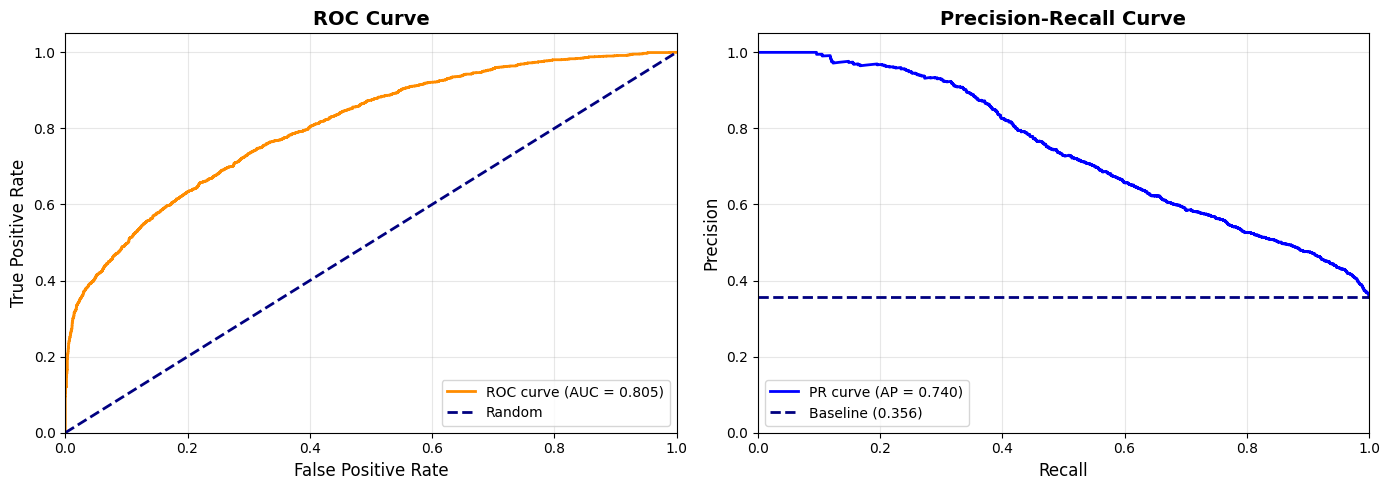

ROC AUC: 0.8046
Average Precision: 0.7404


In [33]:
# ROC曲線とPR曲線をプロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC曲線
fpr, tpr, thresholds_roc = roc_curve(all_y_true, all_y_pred_proba)
roc_auc = auc(fpr, tpr)

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# PR曲線
precision, recall, thresholds_pr = precision_recall_curve(all_y_true, all_y_pred_proba)
avg_precision = average_precision_score(all_y_true, all_y_pred_proba)

ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
ax2.axhline(y=all_y_true.mean(), color='navy', linestyle='--', lw=2, label=f'Baseline ({all_y_true.mean():.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

In [34]:
# 最適閾値の探索
print("=== 最適閾値の探索 ===\n")

# F1スコアが最大になる閾値
f1_scores = []
thresholds_test = np.arange(0.1, 0.9, 0.05)

for threshold in thresholds_test:
    y_pred = (all_y_pred_proba >= threshold).astype(int)
    f1 = f1_score(all_y_true, y_pred, zero_division=0)
    f1_scores.append(f1)

optimal_threshold_f1 = thresholds_test[np.argmax(f1_scores)]
max_f1 = np.max(f1_scores)

print(f"1. F1スコア最大化:")
print(f"   最適閾値: {optimal_threshold_f1:.2f}")
print(f"   F1スコア: {max_f1:.4f}")

# その閾値での詳細な評価
y_pred_optimal = (all_y_pred_proba >= optimal_threshold_f1).astype(int)
acc_optimal = accuracy_score(all_y_true, y_pred_optimal)
prec_optimal = precision_score(all_y_true, y_pred_optimal, zero_division=0)
rec_optimal = recall_score(all_y_true, y_pred_optimal, zero_division=0)

print(f"   Accuracy:  {acc_optimal:.4f}")
print(f"   Precision: {prec_optimal:.4f}")
print(f"   Recall:    {rec_optimal:.4f}")

# Recall重視の閾値（Recall >= 0.7を目指す）
print(f"\n2. Recall重視（目標: Recall >= 0.7）:")
recall_target = 0.7
best_threshold_recall = None

for threshold in sorted(thresholds_test):
    y_pred = (all_y_pred_proba >= threshold).astype(int)
    rec = recall_score(all_y_true, y_pred, zero_division=0)
    if rec >= recall_target:
        best_threshold_recall = threshold
        prec = precision_score(all_y_true, y_pred, zero_division=0)
        f1 = f1_score(all_y_true, y_pred, zero_division=0)
        print(f"   閾値: {threshold:.2f}")
        print(f"   Recall:    {rec:.4f}")
        print(f"   Precision: {prec:.4f}")
        print(f"   F1スコア:  {f1:.4f}")
        break

if best_threshold_recall is None:
    print(f"   Recall >= {recall_target}を満たす閾値が見つかりませんでした")
    # 最もRecallが高い閾値を探す
    max_recall_idx = 0
    max_recall = 0
    for i, threshold in enumerate(thresholds_test):
        y_pred = (all_y_pred_proba >= threshold).astype(int)
        rec = recall_score(all_y_true, y_pred, zero_division=0)
        if rec > max_recall:
            max_recall = rec
            max_recall_idx = i
    
    threshold = thresholds_test[max_recall_idx]
    y_pred = (all_y_pred_proba >= threshold).astype(int)
    prec = precision_score(all_y_true, y_pred, zero_division=0)
    f1 = f1_score(all_y_true, y_pred, zero_division=0)
    print(f"   最大Recall達成閾値: {threshold:.2f}")
    print(f"   Recall:    {max_recall:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   F1スコア:  {f1:.4f}")

# Youden's Indexによる最適閾値（感度と特異度のバランス）
print(f"\n3. Youden's Index（感度と特異度のバランス）:")
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold_youden = thresholds_roc[optimal_idx]

y_pred_youden = (all_y_pred_proba >= optimal_threshold_youden).astype(int)
acc_youden = accuracy_score(all_y_true, y_pred_youden)
prec_youden = precision_score(all_y_true, y_pred_youden, zero_division=0)
rec_youden = recall_score(all_y_true, y_pred_youden, zero_division=0)
f1_youden = f1_score(all_y_true, y_pred_youden, zero_division=0)

print(f"   最適閾値: {optimal_threshold_youden:.4f}")
print(f"   Accuracy:  {acc_youden:.4f}")
print(f"   Precision: {prec_youden:.4f}")
print(f"   Recall:    {rec_youden:.4f}")
print(f"   F1スコア:  {f1_youden:.4f}")

=== 最適閾値の探索 ===

1. F1スコア最大化:
   最適閾値: 0.30
   F1スコア: 0.6447
   Accuracy:  0.7071
   Precision: 0.5672
   Recall:    0.7469

2. Recall重視（目標: Recall >= 0.7）:
   閾値: 0.10
   Recall:    0.9775
   Precision: 0.4067
   F1スコア:  0.5744

3. Youden's Index（感度と特異度のバランス）:
   最適閾値: 0.3674
   Accuracy:  0.7362
   Precision: 0.6223
   Recall:    0.6580
   F1スコア:  0.6397


### ROC曲線とPR曲線の分析（閾値最適化）

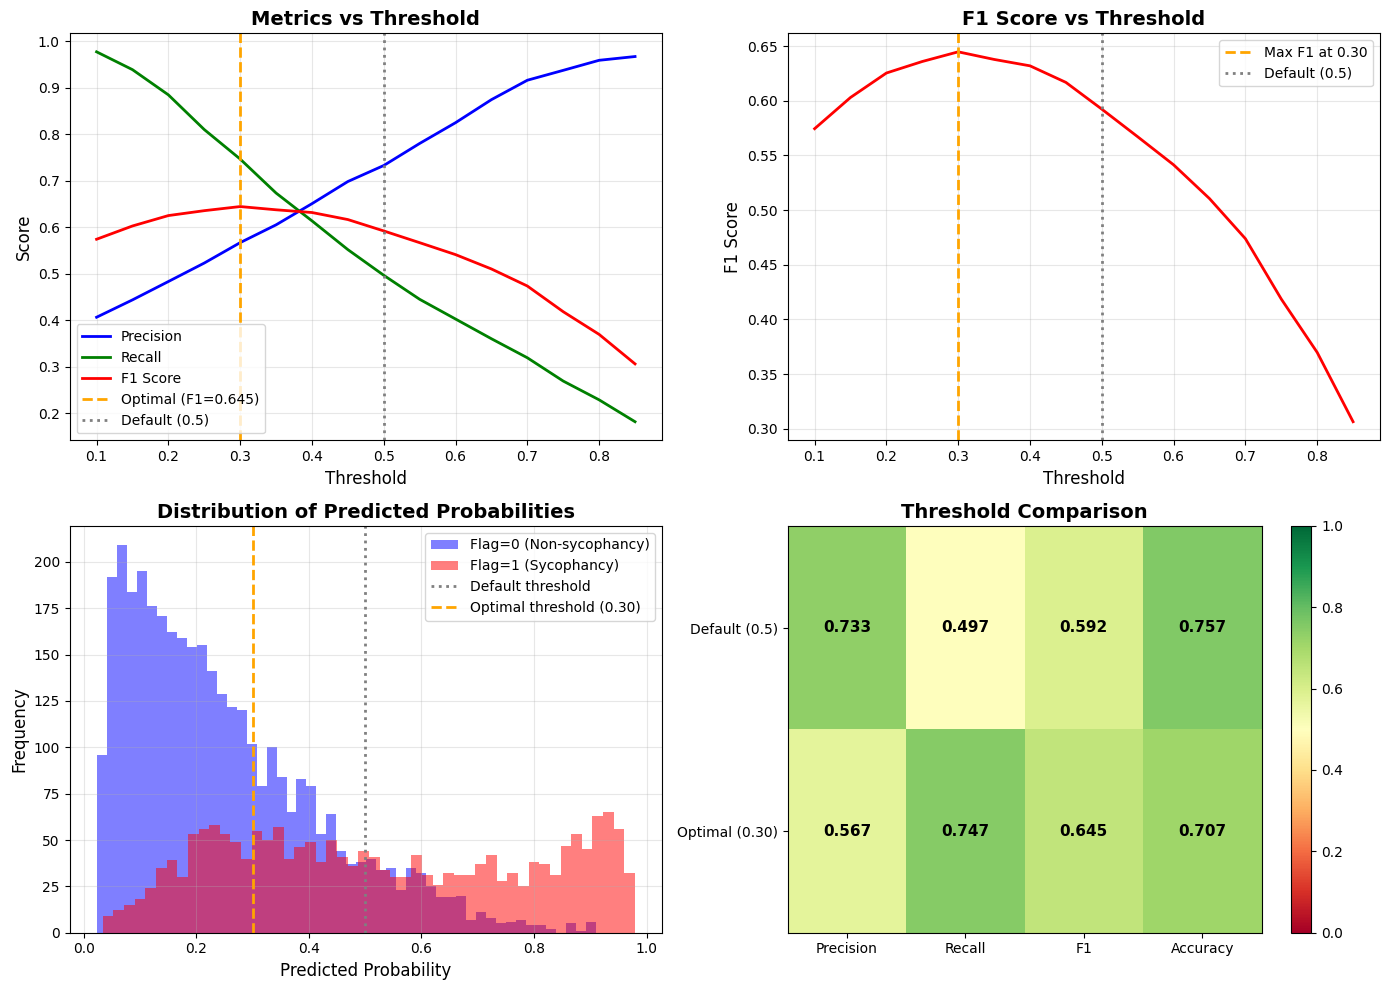

In [35]:
# 閾値ごとのメトリクスをプロット
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Precision, Recall, F1 vs Threshold
ax = axes[0, 0]

precisions = [precision_score(all_y_true, (all_y_pred_proba >= t).astype(int), zero_division=0) for t in thresholds_test]
recalls = [recall_score(all_y_true, (all_y_pred_proba >= t).astype(int), zero_division=0) for t in thresholds_test]
f1s = [f1_score(all_y_true, (all_y_pred_proba >= t).astype(int), zero_division=0) for t in thresholds_test]

ax.plot(thresholds_test, precisions, 'b-', label='Precision', linewidth=2)
ax.plot(thresholds_test, recalls, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_test, f1s, 'r-', label='F1 Score', linewidth=2)
ax.axvline(x=optimal_threshold_f1, color='orange', linestyle='--', label=f'Optimal (F1={max_f1:.3f})', linewidth=2)
ax.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)', linewidth=2)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# F1 Score vs Threshold（拡大図）
ax = axes[0, 1]
ax.plot(thresholds_test, f1s, 'r-', linewidth=2)
ax.axvline(x=optimal_threshold_f1, color='orange', linestyle='--', label=f'Max F1 at {optimal_threshold_f1:.2f}', linewidth=2)
ax.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)', linewidth=2)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# 予測確率の分布
ax = axes[1, 0]
ax.hist(all_y_pred_proba[all_y_true == 0], bins=50, alpha=0.5, label='Flag=0 (Non-sycophancy)', color='blue')
ax.hist(all_y_pred_proba[all_y_true == 1], bins=50, alpha=0.5, label='Flag=1 (Sycophancy)', color='red')
ax.axvline(x=0.5, color='gray', linestyle=':', label='Default threshold', linewidth=2)
ax.axvline(x=optimal_threshold_f1, color='orange', linestyle='--', label=f'Optimal threshold ({optimal_threshold_f1:.2f})', linewidth=2)
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# 混同行列風のヒートマップ（閾値0.5 vs 最適閾値）
ax = axes[1, 1]
y_pred_default = (all_y_pred_proba >= 0.5).astype(int)

comparison_data = {
    'Default (0.5)': {
        'Precision': precision_score(all_y_true, y_pred_default, zero_division=0),
        'Recall': recall_score(all_y_true, y_pred_default, zero_division=0),
        'F1': f1_score(all_y_true, y_pred_default, zero_division=0),
        'Accuracy': accuracy_score(all_y_true, y_pred_default)
    },
    f'Optimal ({optimal_threshold_f1:.2f})': {
        'Precision': prec_optimal,
        'Recall': rec_optimal,
        'F1': max_f1,
        'Accuracy': acc_optimal
    }
}

comparison_df = pd.DataFrame(comparison_data).T
sns_plot = ax.imshow(comparison_df.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(len(comparison_df.columns)))
ax.set_yticks(range(len(comparison_df.index)))
ax.set_xticklabels(comparison_df.columns)
ax.set_yticklabels(comparison_df.index)
ax.set_title('Threshold Comparison', fontsize=14, fontweight='bold')

# セルに値を表示
for i in range(len(comparison_df.index)):
    for j in range(len(comparison_df.columns)):
        ax.text(j, i, f'{comparison_df.values[i, j]:.3f}', 
                ha='center', va='center', color='black', fontsize=11, fontweight='bold')

plt.colorbar(sns_plot, ax=ax)

plt.tight_layout()
plt.show()

### 全データでの最終モデル学習（SHAP分析用）

In [31]:
# 全データで最終モデルを学習（SHAP分析に使用）
print("=== 全データでの最終モデル学習 ===")

# LightGBMデータセット作成
full_train_data = lgb.Dataset(X, label=y)

# パラメータ設定（クロスバリデーションと同じ）
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'max_depth': -1
}

# モデル学習
final_model = lgb.train(
    params,
    full_train_data,
    num_boost_round=100,
    valid_sets=[full_train_data],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(0)]
)

print(f"最終モデルの学習が完了しました (反復回数: {final_model.current_iteration()})")
print("このモデルを使用してSHAP分析を実施します。")

=== 全データでの最終モデル学習 ===
最終モデルの学習が完了しました (反復回数: 100)
このモデルを使用してSHAP分析を実施します。
最終モデルの学習が完了しました (反復回数: 100)
このモデルを使用してSHAP分析を実施します。
